<h2>Palantir analysis notebook</h2>

<h3>Table of contents</h3>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data Processing</a>
<br/>
<a href='#palantir'>Running Palantir</a>
<br/>
<a href='#palantir2'>Visualizing Palantir results</a>
<br/>
<a href='#trends'>Gene expression trends</a>
<br/>
<a href='#clustering'>Clustering of cells and gene expression trends</a>

<a id="intro"></a><h2> Introduction </h2>

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination. 

See <a href="https://www.nature.com/articles/s41587-019-0068-4">our manuscript</a> for more details.

## Imports

In [1]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import os

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Reset random seed
np.random.seed(5)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


<a id="data"></a><h2> Loading data </h2>

We recommend the use of <a href="https://scanpy-tutorials.readthedocs.io/en/latest/index.html">scanpy</a> <a href="https://anndata.readthedocs.io/en/latest/">Anndata</a> objects as the preferred mode of loading and filtering data. 

A sample RNA-seq csv data is available at <a href="https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad">. This sample data will be used to demonstrate the utilization and capabilities of the Palantir package. This dataset contains ~4k cells and ~16k genes and is pre-filtered. Check the <a href="https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html">scanpy introductory tutorial</a> for filtering cells and genes. 



In [ ]:
# Download anndata file using
# !wget https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad -O <data dir>

In [2]:
# Load sample data
palantir_dir = os.path.expanduser(<data dir>)
ad = sc.read(palantir_dir + 'marrow_sample_scseq_counts.h5ad')
ad

AnnData object with n_obs × n_vars = 4142 × 16106

<b>NOTE</b>: Counts are assumed to the normalized. If you have already normalized the data, skip past the `Normalization` section

## Data processing

### Normalization

Normalize the data for molecule count distribution using the `scanpy` interface

In [3]:
sc.pp.normalize_per_cell(ad)

We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a `pseudocount` of 0.1 instead of 1.

In [4]:
palantir.preprocess.log_transform(ad)

### Highly variable gene selection

Highly variable gene selection can also be performed using the `scanpy` interface

In [5]:
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor='cell_ranger')

### PCA

PCA is the first step in data processing for Palantir. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data. 

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.

In [6]:
# Note in the manuscript, we did not use highly variable genes but scanpy by default uses only highly variable genes
sc.pp.pca(ad)

In [7]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Diffusion maps

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [8]:
# Run diffusion maps
pca_projections = pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [9]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

### Visualization

In the manuscript, we used tSNE projection using diffusion components to visualize the data. We now recommend the use of force-directed layouts for visualization of trajectories. Force-directed layouts can be computed by the same adaptive kernel used for determining diffusion maps. `tSNE` on diffusion components can still be computed using the function `tsne = palantir.utils.run_tsne(ms_data)`.

`scanpy` can be used to compute force directed layouts. We recommened the use of the diffusion kernel (see below) for computing force directed layouts
`Force Atlas` package should be installed for this analysis and can be installed using `conda install -c conda-forge fa2`. Note that fa2 is not supported by python3.9

UMAPs are a good alternative to visualize trajectories in addition to force directed layouts.

In [10]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

UMAP or FDL results can be visualized by the `plot_tsne` function.

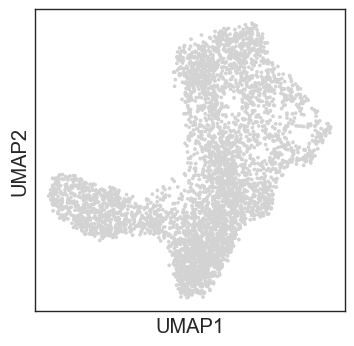

In [11]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(ad, basis='umap')

### MAGIC imputation 

<a href="https://github.com/pkathail/magic">MAGIC</a> is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [12]:
ad.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(ad, dm_res)

Gene expression can be visualized on umaps using the `scanpy` functions. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of HSC gene `CD34`, myeloid gene `MPO` and erythroid precursor gene `GATA1` and  dendritic cell gene `IRF8`. 

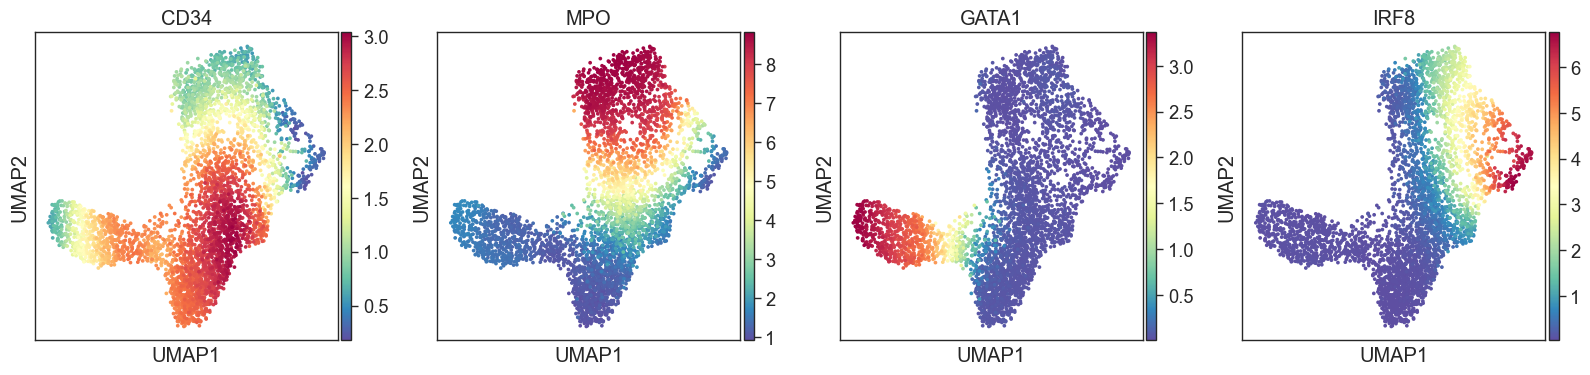

In [13]:
sc.pl.embedding(ad, basis='umap', layer='MAGIC_imputed_data',
               color=['CD34', 'MPO', 'GATA1', 'IRF8'])

### Diffusion maps visualization

The computed diffusion components can be visualized with the following snippet.

In [14]:
umap = pd.DataFrame(ad.obsm['X_umap'], index=ad.obs_names)

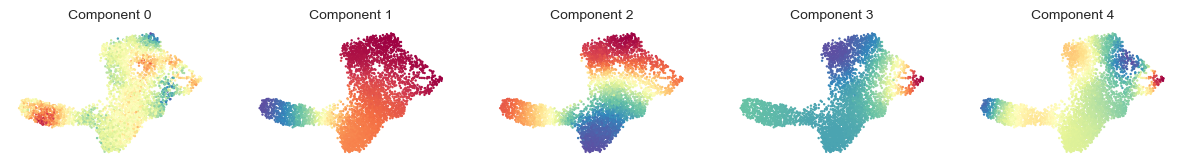

In [15]:
palantir.plot.plot_diffusion_components(umap, dm_res)

<a id="palantir"></a><h2> Running Palantir </h2>

Palantir can be run by specifying an approxiate early cell. 

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the ```terminal_states``` parameter

The start cell for this dataset was chosen based on high expression of CD34.

In [16]:
terminal_states = pd.Series(['DC', 'Mono', 'Ery'], 
                           index=['Run5_131097901611291', 'Run5_134936662236454', 'Run4_200562869397916'])

In [17]:
start_cell = 'Run5_164698952452459'
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.003575698534647624 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling bac

Time for shortest paths: 0.13936636845270792 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir generates the following results 
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the <i>differentiation potential</i> of each cell computed as the entropy of the multinomial terminal state probabilities

The terminal states in this dataset are renamed to reflect the known biology below

In [18]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

<a id="palantir2"></a><h2> Visualizing Palantir results </h2>

Palantir results can be visualized on the tSNE map using the `plot_palantir_results` function

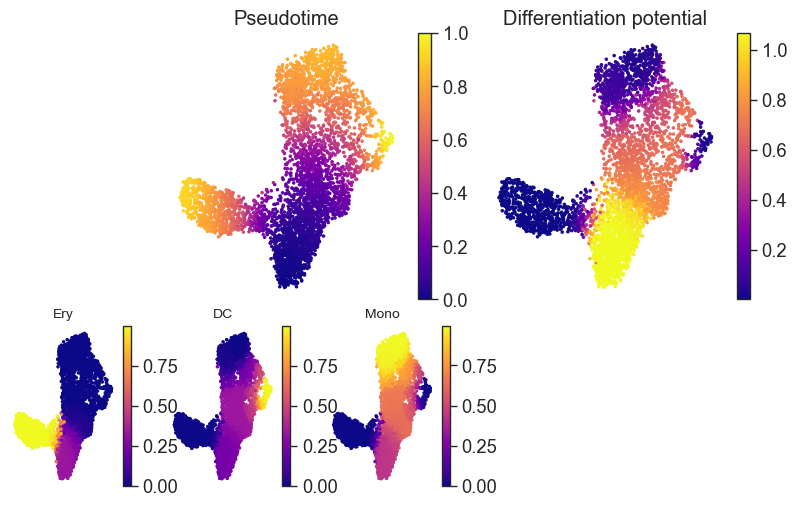

In [19]:
palantir.plot.plot_palantir_results(pr_res, umap)

Terminal state probability distributions of individual cells can be visualized using the `plot_terminal_state_probs` function

/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

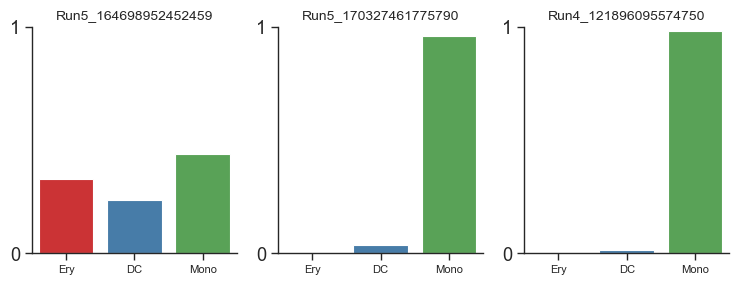

In [21]:
cells = ['Run5_164698952452459', 'Run5_170327461775790', 'Run4_121896095574750', ]
palantir.plot.plot_terminal_state_probs(pr_res, cells) 

The cells can be highlighted on the tSNE map using the `highlight_cells_on_tsne` function

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

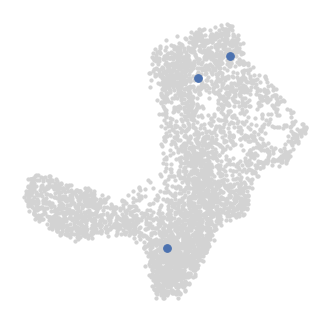

In [22]:
palantir.plot.highlight_cells_on_tsne(umap, cells)

<a id='trends'></a><h2> Gene expression trends </h2>

Palantir uses <a href="https://cran.r-project.org/web/packages/gam/">Generalized Additive Models (GAMs) </a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [23]:
genes = ['CD34', 'MPO', 'GATA1', 'IRF8']
imp_df = pd.DataFrame(ad[:, genes].layers['MAGIC_imputed_data'],
                     index=ad.obs_names, columns=genes)
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

Ery


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Time for processing Ery: 0.0870980699857076 minutes
DC


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Time for processing DC: 0.03753581444422404 minutes
Mono
Time for processing Mono: 0.03537740310033163 minutes


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


The determined trends can be visualized with the `plot_gene_trends` function. A separate panel is generated  for each gene

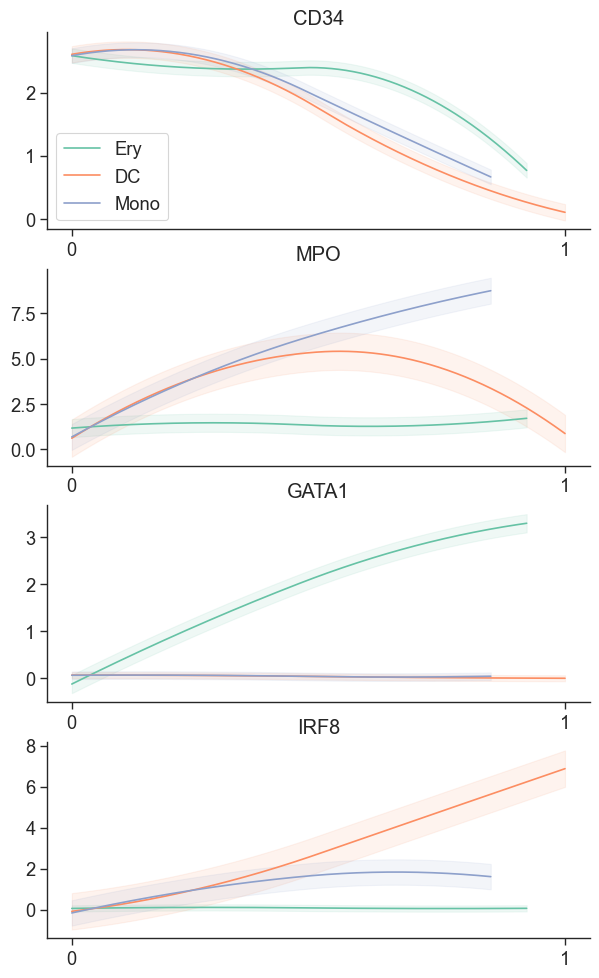

In [24]:
palantir.plot.plot_gene_trends(gene_trends)

Alternatively, the trends can be visualized on a heatmap using

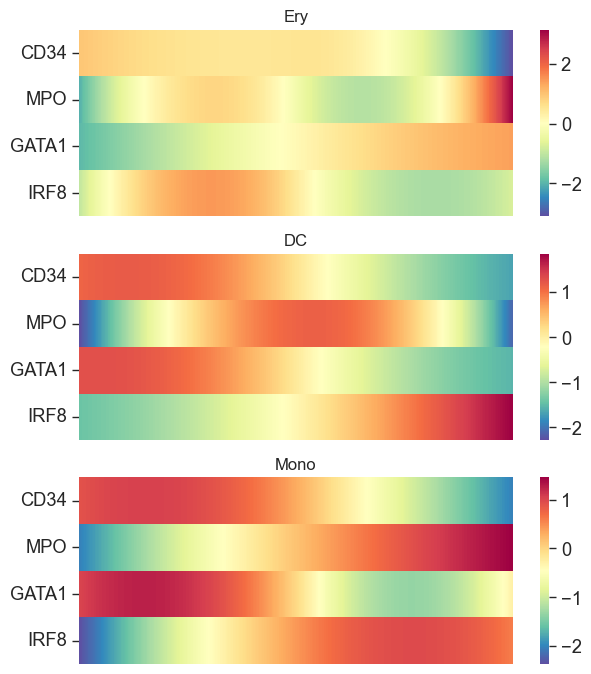

In [25]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

<a id="clustering"></a><h3> Clustering </h3>

Cells can be clustered and visualized using <a href="https://github.com/dpeerlab/PhenoGraph">Phenograph</a> with the following snippet.

In [26]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.7527499198913574 seconds
Jaccard graph constructed in 2.023081064224243 seconds
Wrote graph to binary file in 0.1230630874633789 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.76264
Louvain completed 21 runs in 1.9195232391357422 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.640310049057007 seconds


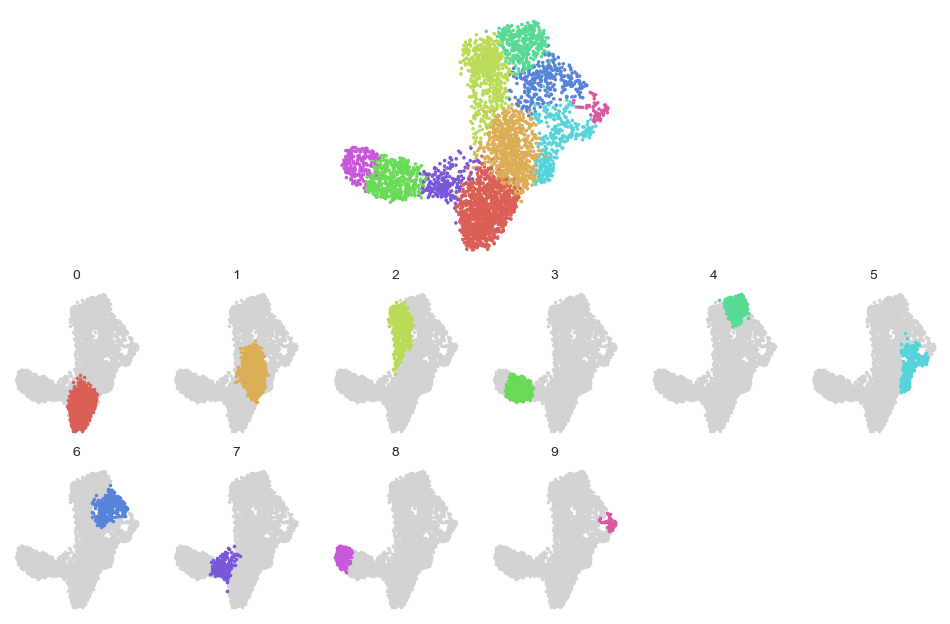

In [27]:
palantir.plot.plot_cell_clusters(umap, clusters )

Similary, gene expression trends can be clustered and visualized using the following snippet. As an example, the first 1000 genes along the erythroid genes are clustered

In [28]:
genes = ad.var_names[:1000]
imp_df = pd.DataFrame(ad[:, genes].layers['MAGIC_imputed_data'], 
                     index=ad.obs_names, columns=genes)
gene_trends = palantir.presults.compute_gene_trends(pr_res, 
                    imp_df.iloc[:, 0:1000], ['Ery'])

Ery


/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/pygam/pygam.py:758: RuntimeWarning: divide by zero encountered in double_scalars
  diff = np.linalg.norm(self.coef_ - coef_new)/np.linalg.norm(coef_new)
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/pygam/pygam.py:758: RuntimeWarning: invalid value encountered in double_scalars
  diff = np.linalg.norm(self.coef_ - coef_new)/np.linalg.norm(coef_new)
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/pygam/distributions.py:200: RuntimeWarning: invalid value encountered in true_divide
  dev /= self.scale
/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/pygam/pygam.py:1247: RuntimeWarning: invalid value encountered in double_scalars
  score = sco

Time for processing Ery: 0.07364916801452637 minutes


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [29]:
# Cluster
trends = gene_trends['Ery']['trends']
gene_clusters = palantir.presults.cluster_gene_trends(trends)

Finding 150 nearest neighbors using minkowski metric and 'auto' algorithm


/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Neighbors computed in 0.13009405136108398 seconds


/usr/local/anaconda3/envs/tfcb2021_scanpy/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Jaccard graph constructed in 2.4879517555236816 seconds
Wrote graph to binary file in 0.08109116554260254 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.613797
Louvain completed 21 runs in 0.9380569458007812 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.584834098815918 seconds


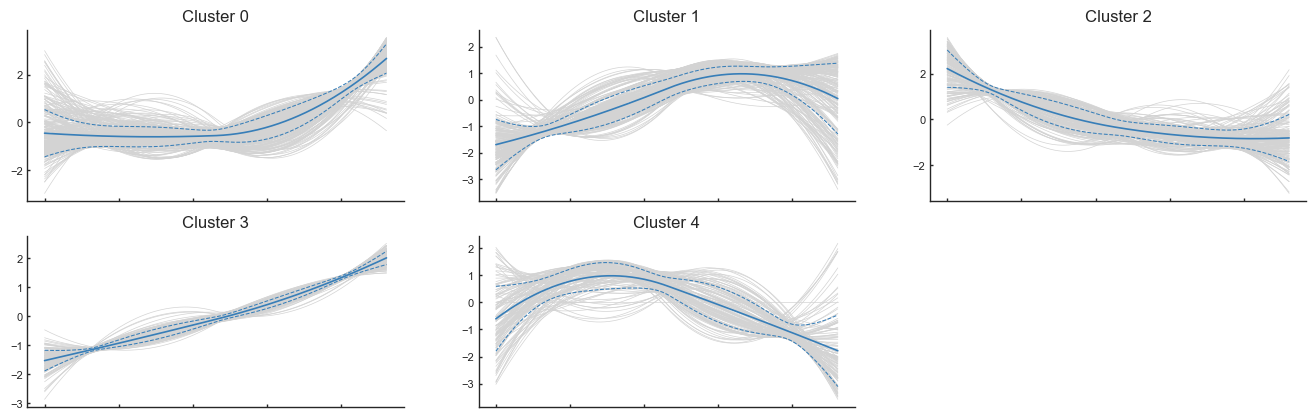

In [30]:
palantir.plot.plot_gene_trend_clusters(trends, gene_clusters)